# データの読み込み（xarray）

In [1]:
import numpy as np
import xarray as xr

In [2]:
ds = xr.open_dataset('d/test3.nc')

In [3]:
ds  # データの確認

<xarray.Dataset>
Dimensions:             (lat: 145, lev: 37, lon: 288)
Coordinates:
  * lev                 (lev) int64 1 2 3 5 7 10 20 ... 875 900 925 950 975 1000
  * lat                 (lat) float64 90.0 88.75 87.5 ... -87.5 -88.75 -90.0
  * lon                 (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
Data variables:
    GeopotentialHeight  (lev, lat, lon) float32 ...

## データの計算（主にNumpy）

In [4]:
a = 6.371e6  # 地球半径 m
g = 9.8  # 重力 m/s^2
omg = 7.292e-5  # 自転角速度 rad/s

緯度経度に関するデータの整理

In [5]:
dlat, dlon = -1.25, 1.25  # deg
dlat, dlon = np.deg2rad(dlat), np.deg2rad(dlon)  # rad

lons, lats = np.meshgrid(ds.lon, ds.lat)  # deg

phi = np.deg2rad(lats)  # rad
cos_phi = np.cos(phi)  # 緯度毎のcos
f = 2 * omg * np.sin(phi)  # 緯度毎のコリオリパラメタ /s
f = np.where((lats==0.), np.nan, f)  # 赤道の地衡風を計算しない

データの選択（Datasetの辞書的な変数指定 [''] -> DadaArrayのセレクトメソッド (.sel( ))）

In [6]:
z = ds['GeopotentialHeight'].sel(lev=500)

### np.gradientとnp.rollを用いた中央差分法の微分(近似)  
[Nympy Mathematical functions - numpy.gradient](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html)  
[note.nkmk.me - Numpy配列をシフト（スクロール）させるnp.roll](https://note.nkmk.me/python-numpy-roll/)  
スライド要参照

In [7]:
dzdy = np.gradient(z, dlat, axis=0) / a
#dzdx = (np.roll(z, -1, axis=1) - np.roll(z, 1, axis=1)) / 2 / dlon / a / cos_phi

地衡風の計算

In [8]:
ug = - dzdy * g / f
vg = dzdx * g / f

データの書き出し（netcdf）

In [9]:
da_ug = xr.DataArray(
    np.array(ug, dtype='f4'), dims=['lat','lon'],
    coords={'lat': ds.lat,
            'lon': ds.lon,},
    name='GeostrophicUwind',
    attrs={'time': '1958-01-01 00:00:00',
           'units': 'm/s',
           'dataset': 'JRA-55'})

da_vg = xr.DataArray(
    np.array(vg, dtype='f4'), dims=['lat','lon'],
    coords={'lat': ds.lat,
            'lon': ds.lon,},
    name='GeostrophicVwind',
    attrs={'time': '1958-01-01 00:00:00',
           'units': 'm/s',
           'dataset': 'JRA-55'})

In [10]:
da_ug.to_netcdf('d/ug.nc')
da_vg.to_netcdf('d/vg.nc')

データの書き出し（フラットバイナリー）

In [11]:
#ug = np.array(ug, dtype='>f4')  # big_endian, float, 4byte
#with open('ug-raw.bin','wb') as o:
#    o.write(d/ug)
    
#vg = np.array(vg, dtype='>f4')
#with open('vg-raw.bin','wb') as o:
#    o.write(d/vg)

### GrADSのnetcdfの要求に合わせた丁寧なデータ作成(不要？)  
[xarray API reference - xarray.Dataset.to_netcdf](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html)  
[xarray User Guide - Reading and writing files](http://xarray.pydata.org/en/stable/user-guide/io.html)  
[cola.gmu.edu grads - Reading NetCDF and HDF files with GrADS](http://cola.gmu.edu/grads/gadoc/SDFdescriptorfile.html)  
[netcdfをいろんなツールで読む](https://ccsr.aori.u-tokyo.ac.jp/~obase/netcdf.html)  

In [12]:
#da_ug.to_netcdf('ug.nc', format='NETCDF4',
#                encoding={'GeostrophicUwind': 
#                          {'dtype': 'float32',
#                           'scale_factor': 0.1,
#                           'add_offset': 0.0,
#                           '_FillValue': 9.999e20}})

# 簡易的な作図（Cartopy）（中級者向け）
[scitools.org.uk cartopy - Using catrtopy with matplotlib](https://scitools.org.uk/cartopy/docs/latest/matplotlib/intro.html)  
[scitools.org.uk cartopy - Cartopy projection list](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)  
[Metpy Mondays - #6 Making a Basic Map with Cartopy](https://youtu.be/iPJjtU7OFSQ)  
[matplotlib - matplotlib.pyplot.quiver](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html)  
[scitools.org.uk cartopy - Regridding vectors with quiver](https://scitools.org.uk/cartopy/docs/v0.17/gallery/regridding_arrows.html)

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

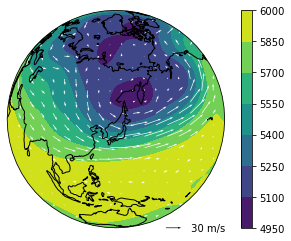

In [14]:
mproj = ccrs.Orthographic(135, 45)  # 作図用の投影
dproj = ccrs.PlateCarree()  # データ格子の投影（緯度経度格子）

fig = plt.figure()  # figureの作成（木枠を用意するイメージ）
ax = fig.add_subplot(111, projection=mproj)  #axesの作成（木枠にキャンバスを広げるイメージ）

ax.coastlines()  # 海岸線の描画

w = (ug**2+vg**2)**(1/2)

#c = ax.contourf(lons, lats, w, np.arange(0,np.nanmax(w),5), transform=dproj)
c = ax.contourf(lons, lats, z, transform=dproj)  # contourf = set gxout shaded
plt.colorbar(c)

q = ax.quiver(lons, lats, ug, vg, regrid_shape=20,  # 風ベクトルの描画
              fc='w', transform=dproj)
ax.quiverkey(q, 0.8, 0, 30,' 30 m/s', fc='k', labelpos='E')  # 基準ベクトルの描画